In [19]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import namedtuple

from statsmodels.tsa.stattools import adfuller

import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer

import torch
import torch.nn as nn
import torch.nn.functional as F

# depending on your OS
# --------------------
from tqdm import trange,tqdm
# from tqdm.notebook import trange,tqdm # works for Linux
# --------------------

from IPython.display import clear_output

%matplotlib inline

In [20]:
MDATA_PATH = 'mdata'

device = 'cpu' # you may try 'cuda' if your machine supports NVIDIA

---

In [3]:
def get_dates():
    return sorted(os.listdir(MDATA_PATH))

def get_tickers():
    dates = get_dates()
    tickers = []
    for date in dates:
        tickers += os.listdir(os.path.join(MDATA_PATH,date))
    return np.unique(tickers)

def get_market_data(ticker):
    agg_mmf_data_raw = []
    for date in get_dates():
        if not os.path.exists(os.path.join(MDATA_PATH,date,ticker)):
            continue
        df = pd.read_csv(
            os.path.join(MDATA_PATH,date,ticker),
            compression='gzip',
            dtype={'bar_time':float,'TIMESTAMP':float},
            index_col=0,
            parse_dates=[2,3],
            date_parser=pd.to_datetime,
        ).sort_values(by=['VOLUME','bar_count']).groupby('bar_time',as_index=False).last()
        agg_mmf_data_raw.append(df)
    agg_mmf_data_raw = pd.concat(agg_mmf_data_raw).set_index('bar_time').sort_index()
    
    agg_price_grid_raw = agg_mmf_data_raw.filter(like='PRICE_GRID')
    agg_vol_grid_raw = agg_mmf_data_raw.filter(like='VOL_GRID')

    agg_mmf_data_raw = agg_mmf_data_raw[ agg_mmf_data_raw.columns[(
        ~agg_mmf_data_raw.columns.str.startswith('EXEC')
        &
        ~agg_mmf_data_raw.columns.str.startswith('PRICE_GRID')
        &
        ~agg_mmf_data_raw.columns.str.startswith('VOL_GRID')
    )]]
    agg_mmf_data_raw.drop([
        'TIMESTAMP','ZERO_SPREAD_ON_TRADE','EMPTY_LOB_SIDE_AFTER_UPDATE','NEGATIVE_SPREAD_AFTER_UPDATE',
        'ZERO_SPREAD_AFTER_UPDATE','EMPTY_LOB_SIDE_ON_TRADE','NEGATIVE_SPREAD_ON_TRADE','bar_count','WEEKDAY'
    ],inplace=True,axis=1)
    
    return agg_mmf_data_raw,agg_price_grid_raw

def get_adf_p_value(dtest):
    dftest = adfuller(dtest, maxlag=10)
    p_value = dftest[1]
    return p_value

def generate_features(mmf_data_raw,price_grid_raw,preserve_cols=['DVOL']):
    dset = (mmf_data_raw.BEST_ASK/2 + mmf_data_raw.BEST_BID/2).to_frame('MID_PRICE') 

    dset['TG_Y'] =  (mmf_data_raw['VWAP'].shift(-2) - mmf_data_raw['VWAP'].shift(-1)) / mmf_data_raw['VWAP'].shift(-1)
    
    dset['R1_X'] =  (dset['MID_PRICE'] - dset['MID_PRICE'].shift(1)) * 100
    dset['R2_X'] =  (dset['MID_PRICE'] - dset['MID_PRICE'].shift(2) ) * 100

    dset['R1V_X'] =  (mmf_data_raw['VWAP'] - mmf_data_raw['VWAP'].shift(1)) * 100
    dset['R2V_X'] =  (mmf_data_raw['VWAP'] - mmf_data_raw['VWAP'].shift(2) ) * 100
    
    dset['RVW_ema_X'] =  mmf_data_raw['VWAP'] - mmf_data_raw['VWAP'].ewm(halflife=8).mean()
    dset['RVW_ema2_X'] =  mmf_data_raw['VWAP'].ewm(halflife=8).mean() - mmf_data_raw['VWAP'].ewm(halflife=16).mean()
    dset['RVW_ema3_X'] =  mmf_data_raw['VWAP'].ewm(halflife=16).mean() - mmf_data_raw['VWAP'].ewm(halflife=32).mean()
    dset['RVW_ema4_X'] =  mmf_data_raw['VWAP'].ewm(halflife=32).mean() - mmf_data_raw['VWAP'].ewm(halflife=64).mean()
    
    for col in preserve_cols:
        dset[f"{col}_X"] = mmf_data_raw[col]
    
    dset['DVOL_EMA3_X'] = dset['DVOL_X'].ewm(halflife=3).mean()
    dset['DVOL_EMA10_X'] = dset['DVOL_X'].ewm(halflife=10).mean()

    dset['BTC_BID_VOL'] = price_grid_raw[['PRICE_GRID_0.991026', 'PRICE_GRID_0.993590', 'PRICE_GRID_0.996154', 'PRICE_GRID_0.998718']].sum(axis=1).abs()
    dset['BTC_ASK_VOL'] = price_grid_raw[['PRICE_GRID_1.001282','PRICE_GRID_1.003846', 'PRICE_GRID_1.006410', 'PRICE_GRID_1.008974']].sum(axis=1).abs()
    dset['OIR_X'] = (dset['BTC_BID_VOL'] - dset['BTC_ASK_VOL']) / (dset['BTC_BID_VOL'] + dset['BTC_ASK_VOL'])
    
    X, y = dset.filter(like='_X'), dset.filter(like='_Y')
    return X,y


---

In [5]:
tickers = get_tickers()
print (tickers)

['Z.ADA' 'Z.BNB' 'Z.BTC' 'Z.DOGE' 'Z.DOT' 'Z.ETC' 'Z.ETH' 'Z.FIL' 'Z.LINK'
 'Z.LTC' 'Z.MATIC' 'Z.THETA' 'Z.UNI' 'Z.XRP']


In [6]:
# SELECT ONE ON YOUR PREFERENCE
ticker = 'Z.DOGE'

In [7]:
agg_mmf_data_raw,agg_price_grid_raw = get_market_data(ticker)

# getting rid of the integrated time series, use with caution
adf_test_p_value = agg_mmf_data_raw.aggregate(get_adf_p_value,axis=0)
preserve_cols = adf_test_p_value.loc[lambda x: x<1e-4].index

X_mmf,y_regr = generate_features(agg_mmf_data_raw,agg_price_grid_raw,preserve_cols=preserve_cols)
y_regr = y_regr * 100
nna_indices = X_mmf.notnull().min(axis=1) & agg_price_grid_raw.notnull().min(axis=1) & y_regr.notnull().min(axis=1)
agg_mmf_data_raw,agg_price_grid_raw,X_mmf,y_regr = agg_mmf_data_raw[nna_indices],agg_price_grid_raw[nna_indices],X_mmf[nna_indices],y_regr[nna_indices]

In [13]:
agg_mmf_data_raw.keys()

Index(['BEST_BID', 'BEST_BID_VOL', 'BEST_ASK', 'BEST_ASK_VOL', 'LAST',
       'VOLUME', 'DVOL', 'HIGH', 'LOW', 'ENTROPY', 'COUNT', 'COUNT_BUY',
       'COUNT_SELL', 'MO_COUNT', 'MO_COUNT_BUY', 'MO_COUNT_SELL', 'MO_AVG',
       'MO_AVG_BUY', 'MO_AVG_SELL', 'BREAK_BEST_DOWN', 'BREAK_BEST_UP',
       'ASK_VOLUME', 'BID_VOLUME', 'VWAP', 'HOUR', 'MINUTE', 'BAR_DURATION'],
      dtype='object')

In [27]:
returns = pd.DataFrame(columns=tickers)

for ticker in ['Z.ADA', 'Z.BTC', 'Z.ETH']:
    print(ticker)
    agg_mmf_data_raw,agg_price_grid_raw = get_market_data(ticker)
    returns[ticker] = (agg_mmf_data_raw['LAST'] - agg_mmf_data_raw['LAST'].shift(1)) / agg_mmf_data_raw['LAST'].shift(1)
    returns.head()

Z.ADA
Z.BTC
Z.ETH


In [28]:
returns.drop[]

,Z.ADA,Z.BNB,Z.BTC,Z.DOGE,Z.DOT,Z.ETC,Z.ETH,Z.FIL,Z.LINK,Z.LTC,Z.MATIC,Z.THETA,Z.UNI,Z.XRP
bar_time,,,,,,,,,,,,,,
2021-01-01 00:02:01.217999872,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-01 00:05:06.065999872,-0.005065,NaN,-0.002071,NaN,NaN,NaN,-0.002529,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-01 00:08:29.527000064,-0.004759,NaN,-0.001703,NaN,NaN,NaN,-0.003539,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-01 00:10:31.216999936,-0.001168,NaN,-0.001684,NaN,NaN,NaN,-0.001497,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-01 00:12:11.052999936,-0.001726,NaN,-0.000488,NaN,NaN,NaN,-0.000859,NaN,NaN,NaN,NaN,NaN,NaN,NaN


C:\Users\Admin\AppData\Local\Temp\ipykernel_628\785260521.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(returns.corr())


<AxesSubplot: >

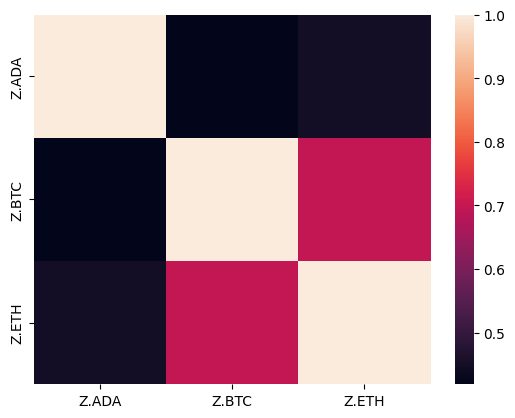

In [30]:
sns.heatmap(returns.corr())

In [36]:
df_corrs = torch.tensor((returns.corr() > 0.5).astype(int).to_numpy())

edge_index = df_corrs.nonzero().t().contiguous().to(device)

C:\Users\Admin\AppData\Local\Temp\ipykernel_628\2685492345.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_corrs = torch.tensor((returns.corr() > 0.5).astype(int).to_numpy())


In [53]:
import networkx as nx
G = nx.from_pandas_edgelist(pd.DataFrame(edge_index).transpose(), source=1, target=0)

{0: Text(1.0, 1.986821512250319e-08, 'Z.ADA')}

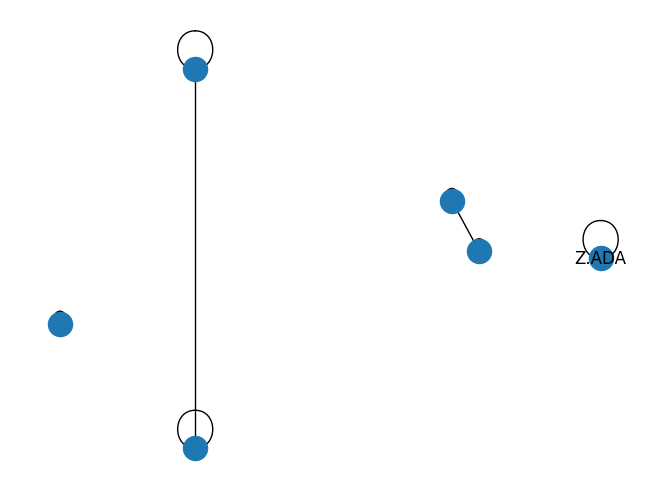

In [56]:
pos = nx.circular_layout(G)
nx.draw(G, pos=pos)
pos_higher = {}

for k, v in pos.items():
    if(v[1]>0):
        pos_higher[k] = (v[0]-0.1, v[1]+0.1)
    else:
        pos_higher[k] = (v[0]-0.1, v[1]-0.1)

labels={}
for i in range(len([selected_tickers])):
    labels[i] = selected_tickers[i]
    
nx.draw(G)
nx.draw_networkx_labels(G, pos, labels=labels)


In [51]:
selected_tickers = ['Z.ADA', 'Z.BTC', 'Z.ETH']

In [10]:
X_mmf

,R1_X,R2_X,R1V_X,R2V_X,RVW_ema_X,RVW_ema2_X,RVW_ema3_X,RVW_ema4_X,BEST_BID_VOL_X,BEST_ASK_VOL_X,...,BREAK_BEST_DOWN_X,BREAK_BEST_UP_X,ASK_VOLUME_X,BID_VOLUME_X,HOUR_X,MINUTE_X,BAR_DURATION_X,DVOL_EMA3_X,DVOL_EMA10_X,OIR_X
bar_time,,,,,,,,,,,,,,,,,,,,,
2021-01-01 00:08:29.527000064,-0.0030,-0.0045,-0.001845,-0.001680,-0.000011,-2.483437e-07,-1.228053e-07,-6.103497e-08,96024.0,1034125.0,...,45.0,15.0,43340642.0,51240202.0,0.0,8.0,2.034610e+11,-5.844945e+05,-4.782706e+05,-0.311013
2021-01-01 00:10:31.216999936,-0.0015,-0.0045,-0.002682,-0.004527,-0.000027,-8.254209e-07,-4.088907e-07,-2.033400e-07,25436.0,35278.0,...,37.0,22.0,29911119.0,51185141.0,0.0,10.0,1.216900e+11,-1.357189e+06,-1.132426e+06,0.222185
2021-01-01 00:12:11.052999936,-0.0005,-0.0020,-0.000136,-0.002818,-0.000022,-1.172062e-06,-5.868994e-07,-2.933055e-07,316022.0,308006.0,...,36.0,24.0,39424065.0,57641628.0,0.0,12.0,9.983600e+10,9.208057e+04,-8.352982e+04,-0.207790
2021-01-01 00:13:57.256000000,-0.0015,-0.0020,-0.001514,-0.001650,-0.000029,-1.677101e-06,-8.428833e-07,-4.218354e-07,129193.0,14986.0,...,21.0,16.0,25338840.0,48488817.0,0.0,13.0,1.062030e+11,-1.997104e+05,-2.577530e+05,-0.619399
2021-01-01 00:14:38.403000064,0.0000,-0.0015,-0.000576,-0.002090,-0.000029,-2.124709e-06,-1.074820e-06,-5.393670e-07,18062.0,13132.0,...,15.0,9.0,34059783.0,49785095.0,0.0,14.0,4.114700e+10,8.415264e+04,-5.550947e+04,0.335725
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-31 23:31:11.516000000,0.0550,0.1020,-0.010221,0.169374,0.003239,1.845142e-03,3.325958e-03,4.610121e-03,172.0,3010.0,...,585.0,601.0,111931295.0,174104534.0,23.0,31.0,1.970200e+11,-1.934503e+05,-3.719447e+05,-0.190668
2021-10-31 23:33:05.256000000,-0.2890,-0.2340,-0.126319,-0.136540,0.001812,1.847150e-03,3.334820e-03,4.636623e-03,1200.0,7742.0,...,514.0,425.0,112980066.0,175574376.0,23.0,33.0,1.137400e+11,-9.848338e+05,-6.168830e+05,0.047111
2021-10-31 23:37:08.680000000,-0.0210,-0.3100,-0.122541,-0.248860,0.000538,1.792662e-03,3.314400e-03,4.648150e-03,893.0,25707.0,...,545.0,488.0,113225574.0,176129565.0,23.0,37.0,2.434240e+11,-5.991347e+05,-5.163215e+05,0.038583


---

Splitting train / test , 70/30 \
Transfrom train and test features to quantiles

In [10]:
n_features = X_mmf.shape[1]
X_train,X_test, y_train,y_test = train_test_split(X_mmf,y_regr,test_size=0.3,shuffle=False)

qt = QuantileTransformer()
X_train = qt.fit_transform(X_train)
X_test = qt.transform(X_test)

In [ ]:
from torch_geometric.data import InMemoryDataset
from tqdm import tqdm

class GraphData(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None, pre_filter=None):
        super().__init__(root, transform, pre_transform, pre_filter)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def processed_file_names(self):
        return ['data.pt']

    def process(self):
        
        dfs, y = self.make_features_df(data_)     
        data_list = []
        idx = data_.shape[0]

        for i in tqdm(range(idx)):
            _ = pd.DataFrame()
            
            for j in range(len(dfs)):
                _[j] = dfs[j].iloc[i]
                
            y_ = y.iloc[i]

            x = torch.tensor(_.to_numpy(), dtype=torch.float).to(device)
            y_ = torch.tensor(y_.to_numpy(), dtype=torch.float).to(device)

            graph = Data(x=x, edge_index=edge_index,  y=y_)
            data_list.append(graph)       
            

        if self.pre_filter is not None:
            data_list = [data for data in data_list if self.pre_filter(data)]

        if self.pre_transform is not None:
            data_list = [self.pre_transform(data) for data in data_list]

        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

        
    def make_features_df(self, data_):
        pass

In [29]:
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, hid_size1, hid_size2):
        super().__init__()
        self.linear1 = nn.Linear(in_features=dataset.num_node_features, out_features=hid_size1)
        self.conv1 = GCNConv(in_channels=hid_size1, out_channels=hid_size2)
        self.linear2 = nn.Linear(in_features=hid_size2, out_features=1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        x = self.linear1(x)
        x = torch.tanh(x)

        x = self.conv1(x, edge_index)
        
        x = self.linear2(x)

        # return torch.tanh(x)
        return x

---

# CatBoost regressor

We will use it as benchmark, i.e. compare our LSTM result with catboost result

In [11]:
cb_regressor = catboost.CatBoostRegressor(depth=8)
cb_regressor.fit(X_train,y_train,silent=True)

y_train_pred_cb = cb_regressor.predict(X_train)
y_test_pred_cb = cb_regressor.predict(X_test)

cb_mse_error_train = metrics.mean_squared_error(y_train,y_train_pred_cb)
cb_mse_error_test  = metrics.mean_squared_error(y_test,y_test_pred_cb)

---

# Define dataset

MMF stands for Market Microstructure Features

In [12]:
# good idea to store all hyperparameters and experiment settings in a dedicated dictionary
# this way you can store the dictionary in wandb and compare all the settings between several experiments

mmf_params = dict(
    hid_size1 = 128,
    hid_size2 = 16,
    batch_size = 128,
    learning_rate = 1e-04,
    episode_len = 128,
    lstm_warm_up = 32
)

In [13]:
# to properly pass our data to LSTM, we need to define how we will iterate through the dataset
# to do that, we define a custom class derived from torch.utils.data.Dataset, and overwrite its __len__ and __getitem__ methods
# these methods allow the dataset to be iterated in a way we need

MMF_Episode = namedtuple('MMF_Episode', ['features', 'targets'])

class MMF_Set(torch.utils.data.Dataset):
    def __init__(self,X,y,episode_len):
        super().__init__()
        
        self.feature_t =  torch.tensor(X, dtype=torch.float32, device=device) # transform X to tensor of type float32 and convert it to DEVICE
        self.target_t  =  torch.tensor(y, dtype=torch.float32, device=device) # transform y to tensor of type float32 and convert it to DEVICE
        self.n_ticks, self.n_features = X.shape
        self.episode_len = episode_len

    def __len__(self):
        return self.n_ticks-self.episode_len+1
    
    # get i-th "rolling window"
    def __getitem__(self,i):
        return MMF_Episode(
            features = self.feature_t[i:i+self.episode_len] , # get the slice of feature_t tensor from i to i+episode_len
            targets =  self.target_t[i:i+self.episode_len] , # get the slice of target_t tensor from i to i+episode_len
        )

In [14]:
mmf_train_feature_set = MMF_Set(X_train.copy(),pd.DataFrame(y_train).values,episode_len=mmf_params['episode_len'])

For debugging purposes

In [15]:
# torch format of the dataset
# splitting to batches
mmf_train_feature_set_t = torch.utils.data.DataLoader(mmf_train_feature_set,batch_size=20,shuffle=True,num_workers=0)

mmf_item = next(iter(mmf_train_feature_set_t))

# make sure this output is [n_batches, n_episodes, n_features], [n_batches, n_episodes, 1]
mmf_item.features.shape, mmf_item.targets.shape

(torch.Size([20, 128, 33]), torch.Size([20, 128, 1]))

---

# Transforming data to torch-compatible format

we have to do this, because any nn.Module accepts only torch tensors as input

In [16]:
X_train_t = torch.tensor(X_train, dtype=torch.float32) # transform X_train to tensor of type float32
X_test_t  = torch.tensor(X_test, dtype=torch.float32) # transform X_test to tensor of type float32

y_train_t = torch.tensor(y_train.values, dtype=torch.float32) # transform y_train of size [n] to tensor of type float32 and shape [n,1]
y_test_t  = torch.tensor(y_test.values, dtype=torch.float32) # transform y_test of size [n] to tensor of type float32 and shape [n,1]

In [17]:
X_train_t.shape, X_test_t.shape

(torch.Size([232382, 33]), torch.Size([99593, 33]))

---

# Network definition

In [18]:
class MMF_LSTM(nn.Module):
    def __init__(self,input_size,hid_size1,hid_size2):
        super().__init__()
        
        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hid_size1) # initialize a nn.LSTM object dealing with batches of input_size = input_size and hidden_size = hid_size1
        
        # the following part is in general of your own freedom of choice
        # instead of what we propose, you may use just one linear transformation hid_size1 -> 1
        
        self.hid_to_hll = nn.Linear(in_features=hid_size1, out_features=hid_size2) # initialize linear transformation with #{input features} = hid_size1 and #{output_features} = hid_size2
        self.hll_to_out = nn.Linear(in_features=hid_size2, out_features=1) # initialize linear transformation with #{input features} = hid_size2 and #{output features} = 1
    
    def forward(self,x):
        # the forward pass has to be as follows:
        # lstm -> first linear layer -> ReLU -> second linear layer
        
        x, _ = self.lstm(x) # get result of lstm network defined in constructor
        x = self.hid_to_hll(x)
        x = F.relu(x)
        output = self.hll_to_out(x)

        return output 

---

# Main train loop

In [19]:
mmf_lstm_model = MMF_LSTM(input_size=n_features, hid_size1=mmf_params['hid_size1'], hid_size2=mmf_params['hid_size2']) # define LSTM object of our custom class with input size = n_features (variable from cell [7]) and hidden sizes from mmf_params
mmf_loss_fn = nn.MSELoss() # define a criterion - mean squared error
mmf_optimizer = torch.optim.Adam(params=mmf_lstm_model.parameters(), lr=mmf_params['learning_rate']) # define Adam optimizer receiving mmf_lst_model parameters and learning rate defined in mmf_params

mmf_activation_fn = torch.tanh # define activation function - hyperbolic tangent
mmf_warm_up = mmf_params['lstm_warm_up'] # define a warm-up window to start training the model, from mmf_params

In [20]:
# lists to store performance metrics of the learning

train_loss_history = []
max_gradient_history = []
mse_train_history = []
mse_test_history = []

In [21]:
mmf_train_feature_set

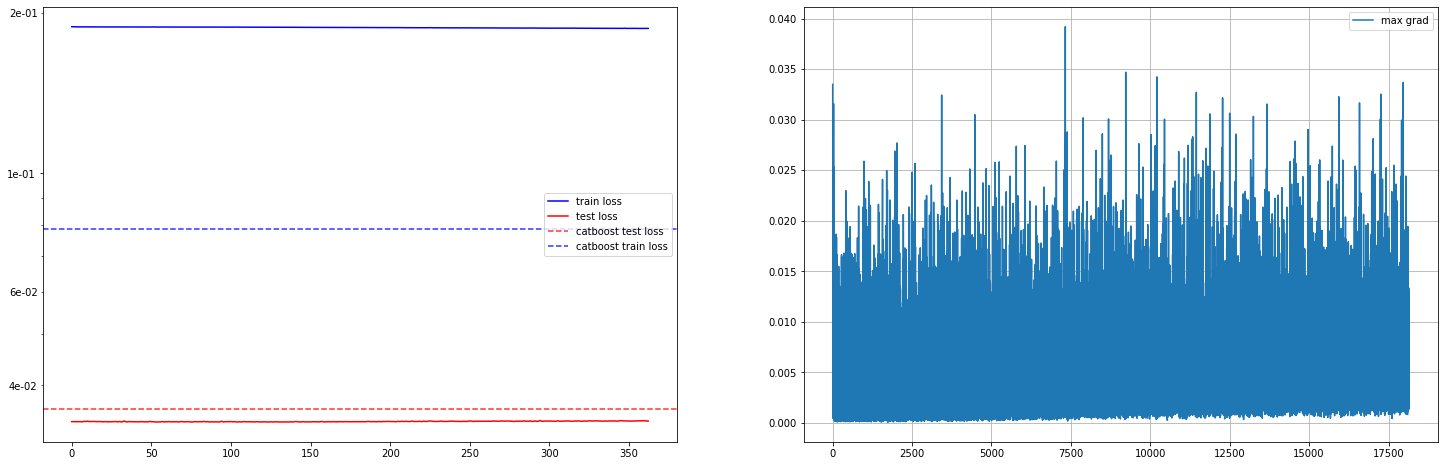

100%|██████████| 1815/1815 [20:28<00:00,  1.48it/s]


In [22]:
for epoch in range(10): # you may vary it, or think out of some stop criterion
    mmf_train_feature_set_t = torch.utils.data.DataLoader(mmf_train_feature_set,batch_size=mmf_params['batch_size'],shuffle=True,num_workers=0)
    try:
        with tqdm(mmf_train_feature_set_t) as progressbar:
            for mmf_episode in progressbar:
                predicted_return = mmf_lstm_model(mmf_episode[0])  # get mmf_lstm_model prediction calculated on the current episode features
                #print(mmf_episode[0].shape, mmf_episode[1].shape, type(mmf_episode), predicted_return.shape)
                train_loss = mmf_loss_fn(input=predicted_return, target=mmf_episode[1]) # calculate loss between actual and predicted values. please ignore the starting warm-up window in loss calculation
                train_loss_history.append(train_loss.item()) # store the loss of the current episode
                mmf_optimizer.zero_grad() # set the gradients of all optimized tensors to zero
                train_loss.backward() # backward propagation
                mmf_optimizer.step() # take an optimization step

                # it is in general a good idea to monitor max gradient and to be able to clip if necessary it using:
                # nn.utils.clip_grad_value_(mmf_lstm_model.parameters(), clip_value=1.0)
                max_gradient_history.append( np.max([torch.max(p.grad).item() for p in mmf_lstm_model.parameters() if p.grad is not None]) )

                if len(train_loss_history) % 50 == 0:
                    mmf_lstm_model.train(False) # disable learning mode

                    mse_train_history.append( mmf_loss_fn(mmf_activation_fn(mmf_lstm_model(X_train_t)),y_train_t).item() ) # losses calculcated on the whole history /
                    mse_test_history.append( mmf_loss_fn(mmf_activation_fn(mmf_lstm_model(X_test_t)),y_test_t).item() )    # unlike row #8 where the current episode only

                    mmf_lstm_model.train(True) # enable learning mode

                    clear_output(True)

                    fgs,axs = plt.subplots(1,2, figsize=[25,8])

                    axs[1].plot(max_gradient_history, label='max grad')
                    axs[1].legend(loc='best')
                    axs[1].grid()

                    axs[0].plot(mse_train_history, label='train loss', color='blue')
                    axs[0].plot(mse_test_history, label='test loss', color='red')
                    axs[0].set_yscale('log')
                    axs[0].yaxis.set_major_formatter(plt.LogFormatter())
                    axs[0].yaxis.set_minor_formatter(plt.LogFormatter())
                    axs[0].axhline(y=cb_mse_error_test, color='red', linestyle='--', alpha=0.8, label='catboost test loss')
                    axs[0].axhline(y=cb_mse_error_train, color='blue', linestyle='--', alpha=0.8, label='catboost train loss')
                    axs[0].legend(loc='best')

                    plt.show()
    except KeyboardInterrupt:
        pass